# Data science with xarray

Hello and welcome to your intro to `xarray` for data science as part of NCI's Parallel Python data science course.

This notebook is designed to cover the fundamentals of `xarray` highlighting some similarities with tools you have already been introduced to such as `NumPy` and `CuPy` and some of the advantages of using `xarray`.


## Intro

First of all what is `xarray`? `xarray` is a project that came out of climate and geophysics research, recognising the need for rapid, scalable and easily manipulated N dimensional array data **with labels and metadata**. 

But wait, doesn't `NumPy` provide an N Dimensional array? Yes it does, but `xarray` provides the ability to use labelled and metadata rich arrays, providing to quote the manual a " more intuitive, more concise, and less error-prone developer experience"

This is done by providing a label based API that simplifies a lot of the manual book keeping of working with `numpy` arrays directly.

No longer will you forget what experiment this data came from, what that tensor dimension was, or what array position corresponded to with time point! Even better these, augmented N dimensional arrays can be combined to make massive datasets, enabling analysis of huge volumes of data. It's all there in  the one datastructure that can be easily stored and shared, as is done on a massive scale using `xarray` in the climate modelling, geophysics, and astrophysics communities to name just a few. 


Alright, lets jump in!

## Crash course

In [2]:
# lets import xarray and numpy
import xarray as xr
import numpy as np

The `DataArray` is the `xarray` equivalent of the `numpy` `ndarray` and will be the first focus of our intro. Lets make a 2 x 3 DataArray using a numpy array, so we can get the hang of how to work with it. 

In [3]:
inp = np.arange(6).reshape(2,3)
data = xr.DataArray(inp, dims=("x", "y"))
data

<xarray.DataArray (x: 2, y: 3)>
array([[0, 1, 2],
       [3, 4, 5]])
Dimensions without coordinates: x, y

We can see that our data array looks a lot like a numpy array, but with two labelled dimensions `x` and `y`. We can access our values directly using the `values` attribute as shown below. 

In [4]:
data.values

array([[0, 1, 2],
       [3, 4, 5]])

We can also access our dimensions using the `dims` attribute as shown below

In [5]:
data.dims

('x', 'y')

The eagle eyed amongst you may have  spotted the `coords` attribute. This is used to associate a value along a particular axis with another value, that could for example correspond to the time or location it was measured. The possibilities are only limited by your imagination

We set our `coords` using a dictionary corresponding to the `coords` along a particular axis.

In [6]:
coords = {"x":[10,20], "y":[0.1, 0.2, 0.3]}
data = data.assign_coords(coords)

**Notice the detail above**, we had to assign our `DataArray` to a new object (in this case we overwrote `data`) for our change to persist. This pattern will be familiar to those who use `pandas`.


## Indexing

Okay cool, how can we access the data in our array? We can use four kinds of slicing. 

* Numpy like using integer locations
* using `loc` like in pandas
* using an integer select (`isel`), combining a dimension name and integer label
* using a selection (`sel`) based on coordinate combining a dimension name and coordinate value

The following selections all give the same set of values, those at `x=10`:

Numpy like using array indexing:

In [7]:
data[0, :]

<xarray.DataArray (y: 3)>
array([0, 1, 2])
Coordinates:
    x        int64 10
  * y        (y) float64 0.1 0.2 0.3

Pandas like using `loc`

In [8]:
data.loc[10]

<xarray.DataArray (y: 3)>
array([0, 1, 2])
Coordinates:
    x        int64 10
  * y        (y) float64 0.1 0.2 0.3

An xarray integer selection

In [9]:
data.isel(x=0)

<xarray.DataArray (y: 3)>
array([0, 1, 2])
Coordinates:
    x        int64 10
  * y        (y) float64 0.1 0.2 0.3

An xarray selection

In [10]:
data.sel(x=10)

<xarray.DataArray (y: 3)>
array([0, 1, 2])
Coordinates:
    x        int64 10
  * y        (y) float64 0.1 0.2 0.3

When dealing with a complicated multidimensional dataset, I and the creators of `xarray` would argue that the last two are simple and powerful.

Note that we can also use `pandas` style `DataArray.dim` indexing to access a given dimension eg:


In [11]:
data.x

<xarray.DataArray 'x' (x: 2)>
array([10, 20])
Coordinates:
  * x        (x) int64 10 20

aggregation operations can also use dimension labels eg:

In [12]:
data.mean(dim="x")

<xarray.DataArray (y: 3)>
array([1.5, 2.5, 3.5])
Coordinates:
  * y        (y) float64 0.1 0.2 0.3

## Metadata

When dealing with complex data another advantage of `xarray` is metadata. Using the `.attrs`  `dict` attribute of `DataArray` we can associate any arbitrary field with our array data. For example lets label our current dataset:


In [13]:
data.attrs["long_name"] = "random array"
data.attrs["units"] = "rad/second"
data.attrs["description"] = "A random variable created as an example."
data.attrs["arbitrary"] = "arbitrary"


We can also associate our dimensions with metadata. For example lets add some metadata with our `x` dimension. 

Note here that we use pandas style `data.dim` accessing as demonstrated above.

In [14]:
data.x.attrs["units"] = "x units"
data.x.attrs["name"] = "name of x dimension"

Of course, just like a numpy array we can do broadcasted operations accross the whole array

In [15]:
data += 100
data

<xarray.DataArray (x: 2, y: 3)>
array([[100, 101, 102],
       [103, 104, 105]])
Coordinates:
  * x        (x) int64 10 20
  * y        (y) float64 0.1 0.2 0.3
Attributes:
    long_name:    random array
    units:        rad/second
    description:  A random variable created as an example.
    arbitrary:    arbitrary

And use many of the standard numpy style shortcuts such as `.T` 

In [16]:
data.T

<xarray.DataArray (y: 3, x: 2)>
array([[100, 103],
       [101, 104],
       [102, 105]])
Coordinates:
  * x        (x) int64 10 20
  * y        (y) float64 0.1 0.2 0.3
Attributes:
    long_name:    random array
    units:        rad/second
    description:  A random variable created as an example.
    arbitrary:    arbitrary

## Broadcasting, operations and labelled dimensions

A fantastic feature of xarray is that operations are dimension specific. Let me show you what I mean.

We are going to make three arrays for demonstration purposes. Array `x` and `y` have different `dims` while `x` and `z` share the `x` dimension.

In [17]:
# has x as dimension
x = xr.DataArray(np.arange(10), dims="x", coords= {"x": np.arange(10)/10})

# has y as dimension
y = xr.DataArray(np.arange(3), dims="y", coords = {"y": np.arange(3)/10})

# has x dimension
z = xr.DataArray(np.arange(3), dims="x", coords = {"x": np.arange(3)/10})

So what happens when I do an operation on arrays with non-matching dimensions?


In [18]:
print(x)
print(y)
print(z)


<xarray.DataArray (x: 10)>
array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Coordinates:
  * x        (x) float64 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9
<xarray.DataArray (y: 3)>
array([0, 1, 2])
Coordinates:
  * y        (y) float64 0.0 0.1 0.2
<xarray.DataArray (x: 3)>
array([0, 1, 2])
Coordinates:
  * x        (x) float64 0.0 0.1 0.2


In [19]:
# result broadcast
result = x*y
result

<xarray.DataArray (x: 10, y: 3)>
array([[ 0,  0,  0],
       [ 0,  1,  2],
       [ 0,  2,  4],
       [ 0,  3,  6],
       [ 0,  4,  8],
       [ 0,  5, 10],
       [ 0,  6, 12],
       [ 0,  7, 14],
       [ 0,  8, 16],
       [ 0,  9, 18]])
Coordinates:
  * x        (x) float64 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9
  * y        (y) float64 0.0 0.1 0.2

Thats interesting! We actually get an **outer product** (tensor product for more than two matching dimensions) formed by broadcasting accross the non-matching dimensions.  

When dimensions and coordinates match, we can easily broadcast accross those instead.

In [20]:
# result broadcast on matching dimension and coordinates
result = x*z
result


<xarray.DataArray (x: 3)>
array([0, 1, 4])
Coordinates:
  * x        (x) float64 0.0 0.1 0.2

The net result of all of this is that we don't need to manually keep track of dimension ordering, indexing and alignment of our coordinates as you would have to do in numpy and don't have to pad arrays with dummy data.

As an example of this, lets multiply our array by its transpose, noting that it is not a square matrix.

In [21]:
ten_by_three = x*y
ten_by_three

<xarray.DataArray (x: 10, y: 3)>
array([[ 0,  0,  0],
       [ 0,  1,  2],
       [ 0,  2,  4],
       [ 0,  3,  6],
       [ 0,  4,  8],
       [ 0,  5, 10],
       [ 0,  6, 12],
       [ 0,  7, 14],
       [ 0,  8, 16],
       [ 0,  9, 18]])
Coordinates:
  * x        (x) float64 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9
  * y        (y) float64 0.0 0.1 0.2

In [22]:
ten_by_three_transpose = ten_by_three.T
ten_by_three_transpose

<xarray.DataArray (y: 3, x: 10)>
array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18]])
Coordinates:
  * x        (x) float64 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9
  * y        (y) float64 0.0 0.1 0.2

In [23]:
result = ten_by_three*ten_by_three.T
result

<xarray.DataArray (x: 10, y: 3)>
array([[  0,   0,   0],
       [  0,   1,   4],
       [  0,   4,  16],
       [  0,   9,  36],
       [  0,  16,  64],
       [  0,  25, 100],
       [  0,  36, 144],
       [  0,  49, 196],
       [  0,  64, 256],
       [  0,  81, 324]])
Coordinates:
  * x        (x) float64 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9
  * y        (y) float64 0.0 0.1 0.2

here, xarray took care of aligning our dimensions based on **dimension labels** even though the order of dimensions was reversed in our transpose.

This is not possible in numpy as show below

In [24]:
a = np.outer(np.arange(10), np.arange(3))
a*a.T

ValueError: operands could not be broadcast together with shapes (10,3) (3,10) 

## Saving data and serialising

A lot of the functionality in `xarray` is based on the netcdf binary format, and as such the reccomended format for saving a `DataArray` is as a netcdf file. 

We need to import either `scipy` or `netcdf4-python` to provide the interface with the format. 

In [25]:
import scipy
result.to_netcdf("array.nc")

Some intro to functions

In [26]:
# construct our grids
spatial_density = 40
time_density = 1001
spatial_domain = (-5,5)
time_domain = (0,10)

x = np.linspace(spatial_domain[0], spatial_domain[1], spatial_density)
y = np.linspace(spatial_domain[0], spatial_domain[1], spatial_density)
z = np.linspace(spatial_domain[0], spatial_domain[1], spatial_density)
time = np.linspace(time_domain[0], time_domain[1], time_density)



scale_func = lambda x, y, z, t: np.cos(1*x + 2*y + 3*z + np.sin(x*y*t))

data = scale_func(*np.meshgrid(x, y, z, time))

da = xr.DataArray(data, dims=['x', 'y', 'z', 'time'], 
                  coords={'x':x, 'y':y, 'z':z, 'time':time})

In [27]:
da

<xarray.DataArray (x: 40, y: 40, z: 40, time: 1001)>
array([[[[ 1.54251450e-01, -9.24021698e-02, -3.18887758e-01, ...,
           9.01023889e-01,  9.14733515e-01,  9.02439049e-01],
         [-5.76436469e-01, -7.58992893e-01, -8.88371763e-01, ...,
           3.45614383e-01,  3.76131026e-01,  3.48684400e-01],
         [-9.82528338e-01, -9.98188564e-01, -9.57606424e-01, ...,
          -4.04413385e-01, -3.74273893e-01, -4.01417262e-01],
         ...,
         [ 3.23291541e-02,  2.76104561e-01,  4.89712805e-01, ...,
          -8.04551348e-01, -8.23551197e-01, -8.06491172e-01],
         [ 7.18445946e-01,  8.66910027e-01,  9.58299552e-01, ...,
          -1.64931792e-01, -1.97113281e-01, -1.68159677e-01],
         [ 1.00000000e+00,  9.69551427e-01,  8.87260051e-01, ...,
           5.67562192e-01,  5.40320722e-01,  5.64863897e-01]],

        [[-1.01366067e-01, -3.30187755e-01, -5.29752527e-01, ...,
           7.05465598e-01,  7.62960271e-01,  7.82332369e-01],
         [-7.64826022e-01, -8.93793278e-01, -9.70558675e-01, ...,
           1.38486535e-02,  9.84894323e-02,  1.28811991e-01],
         [-9.97606243e-01, -9.54096559e-01, -8.64835364e-01, ...,
          -6.85566580e-01, -6.21441604e-01, -5.97243464e-01],
...
         [-9.97606243e-01, -9.86293843e-01, -9.25832976e-01, ...,
          -5.78566705e-01, -5.07404489e-01, -4.80871597e-01],
         [-7.64826022e-01, -5.93828801e-01, -4.02277305e-01, ...,
          -9.83010625e-01, -9.63931959e-01, -9.55361002e-01],
         [-1.01366067e-01,  1.33026054e-01,  3.47803979e-01, ...,
          -8.33913290e-01, -8.77661527e-01, -8.91878881e-01]],

        [[ 1.00000000e+00,  9.69551427e-01,  8.87260051e-01, ...,
           5.67562192e-01,  5.40320722e-01,  5.64863897e-01],
         [ 7.18445946e-01,  5.26230557e-01,  3.16597221e-01, ...,
           9.80457305e-01,  9.73495745e-01,  9.79808029e-01],
         [ 3.23291541e-02, -2.13415006e-01, -4.32344072e-01, ...,
           8.41248959e-01,  8.58487421e-01,  8.43014316e-01],
         ...,
         [-9.82528338e-01, -9.07034939e-01, -7.85909861e-01, ...,
          -7.10878489e-01, -6.87486947e-01, -7.08572309e-01],
         [-5.76436469e-01, -3.58776708e-01, -1.34526338e-01, ...,
          -9.99941474e-01, -9.99052164e-01, -9.99900700e-01],
         [ 1.54251450e-01,  3.91511596e-01,  5.92610057e-01, ...,
          -7.25929307e-01, -7.48043006e-01, -7.28176899e-01]]]])
Coordinates:
  * x        (x) float64 -5.0 -4.744 -4.487 -4.231 ... 4.231 4.487 4.744 5.0
  * y        (y) float64 -5.0 -4.744 -4.487 -4.231 ... 4.231 4.487 4.744 5.0
  * z        (z) float64 -5.0 -4.744 -4.487 -4.231 ... 4.231 4.487 4.744 5.0
  * time     (time) float64 0.0 0.01 0.02 0.03 0.04 ... 9.96 9.97 9.98 9.99 10.0

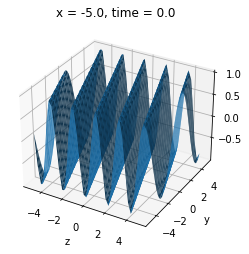

In [28]:
func2dt0 = da.sel(time=0.0, x=-5.0)
func2dt0.plot.surface()


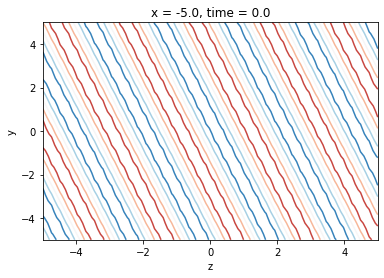

In [29]:
func2dt0.plot.contour()

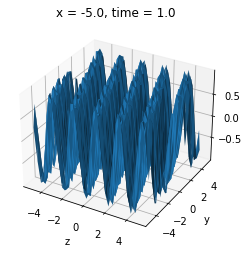

In [30]:
func2d_t1 = da.sel(time=1.0, x=-5.0)
func2d_t1.plot.surface()

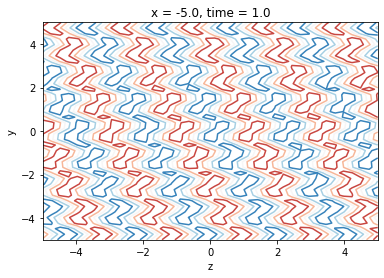

In [31]:
func2d_t1.plot.contour()

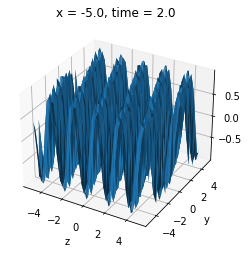

In [32]:
func2d_t2 = da.sel(time=2.0, x=-5.0)
func2d_t2.plot.surface()

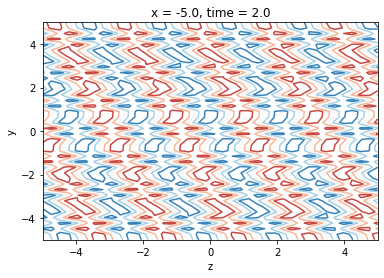

In [33]:
func2d_t2.plot.contour()

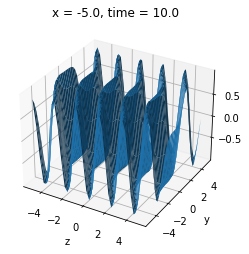

In [34]:
func2d_t10 = da.sel(time=10.0, x=-5.0)
func2d_t10.plot.surface()

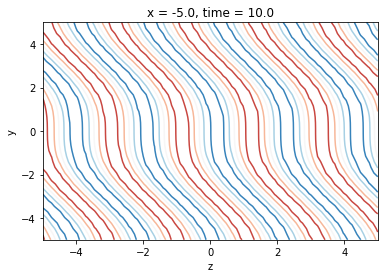

In [35]:
func2d_t10.plot.contour()

lets use some of `xarrays` powerful indexing to pull out a point at an index.

In [36]:
da.sel(x=0.0, y=1.0, z=3.0, time=3.0, method='nearest')

<xarray.DataArray ()>
array(-0.61091818)
Coordinates:
    x        float64 0.1282
    y        float64 0.8974
    z        float64 2.949
    time     float64 3.0

## Datasets and grouping 

The functionality we have covered so far is fantastic, but what if we want to group arrays together in some kind of coherent way?

Don't worry `xarray` has us covered with a `Dataset`. Lets make a few arrays and combine them in a dataset, this time using a more realistic example of coordinates, variables and metadata.

We are going to use a evaluate a functions on a regular 3D grid, that varies over time!